In [1]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

In [2]:
from torchvision import datasets as Datasets
from torchvision import transforms as T

mnist_train_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
])

mnist_test_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
])

train_dataset = Datasets.MNIST(root='../../autoencoder', train=True, download=False, transform=mnist_train_transform)
test_dataset = Datasets.MNIST(root='../../autoencoder', train=False, download=False, transform=mnist_test_transform)

/home/ritish/prog/ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=16, pin_memory=True)

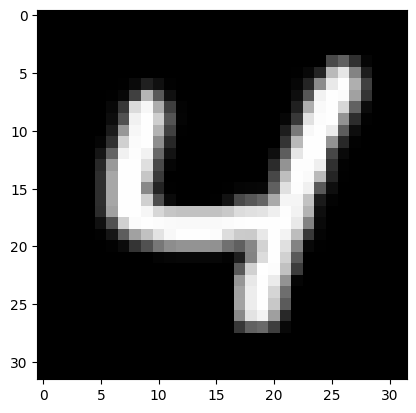

In [5]:
# Show image from train loader
img, _ = next(iter(train_loader))
plt.imshow(img[0][0], cmap='gray')

In [6]:
# Calculate pair wise distance
a = torch.randn(100, 4).cuda()
b = torch.randn(200, 4).cuda()
distances = torch.sqrt(torch.sum(a**2, dim=1, keepdim=True) + torch.sum(b**2, dim=1).view(-1, b.size(0)) - 2 * a @ b.T)
min_idx = torch.argmin(distances, dim=1)
distances_torch = torch.cdist(a, b)

print(torch.allclose(distances, distances_torch, atol=1e-5))

True


In [41]:
# Running time comparison
import time
ts = time.time()
for i in range(50000):
    dist = (torch.sum(a**2, dim=1, keepdim=True) + torch.sum(b**2, dim=1).view(-1, b.size(0)) - 2 * a @ b.T)
print(time.time() - ts)

ts = time.time()
for i in range(50000):
    dist = torch.cdist(a, b)
print(time.time() - ts)

2.7335562705993652
3.2499489784240723


In [7]:
class VQVAE(nn.Module):
    def __init__(self, K=5, D=4, beta=0.2):
        super().__init__()
        self.K = K
        self.D = D
        self.beta = beta

        self.encoder = nn.Sequential(
            self.conv_block(1, 16, 4, 2, 1),
            self.conv_block(16, 32, 4, 2, 1),
            self.conv_block(32, 64, 4, 2, 1),
            self.conv_block(64, D, 3, 1, 1),
        )

        # Embedding table
        self.embedding = nn.Embedding(K, D)

        self.decoder = nn.Sequential(
            self.convT_block(D, 64, 3, 1, 1),
            self.convT_block(64, 32, 4, 2, 1),
            self.convT_block(32, 16, 4, 2, 1),
            self.convT_block(16, 1, 4, 2, 1, batch_norm=False, act='sigmoid'),
        )

    def forward(self, x):
        z = self.encoder(x)
        B, C, H, W = z.size()
        z = z.permute(0, 2, 3, 1)       # (B, H, W, D)
        z = z.reshape(-1, self.D)       # (B * H * W, D)

        z_q = self.quantize(z)          # z_q: (B, D)
        
        # Codebook loss + Commitment loss
        loss_vq = torch.mean((z_q - z.detach())**2) + self.beta * torch.mean((z - z_q.detach())**2)

        # Straight through estimation of gradients (Gradients of z_q will go to z)
        z_q = z + (z_q - z).detach()
        z_q = z_q.view(B, H, W, self.D).permute(0, 3, 1, 2)
        z_q = self.decoder(z_q)

        return z_q, loss_vq

    def quantize(self, z):
        dist_sq = torch.sum(z**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1).view(-1, self.embedding.weight.size(0)) - 2 * z @ self.embedding.weight.T  # (B, K)
        min_idx = torch.argmin(dist_sq, dim=-1)         # (B*H*W,)
        z_q = self.embedding(min_idx)                   # (B*H*W, D)
        return z_q

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm=True):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=(not batch_norm)),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.ReLU(),
        )
    
    def convT_block(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm=True, act='relu'):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=(not batch_norm)),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.ReLU() if act == 'relu' else nn.Sigmoid(),
        )

In [8]:
def xavier_init(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE(K=8, D=4, beta=0.2).to(device)
xavier_init(model)

In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [28]:
epochs = 3
for epoch in range(epochs):
    model.train()
    tqdm_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
    for img, _ in tqdm_loader:
        img = img.to(device)
        optimizer.zero_grad()

        # Forward pass
        img_recon, loss_vq = model(img)
        loss_recon = F.mse_loss(img_recon, img)
        loss = loss_recon + loss_vq

        loss.backward()
        optimizer.step()

        tqdm.set_description(tqdm_loader, f'Loss: {loss.item():.4f}, Recon Loss: {loss_recon.item():.4f}, VQ Loss: {loss_vq.item():.4f}')

Loss: 0.1004, Recon Loss: 0.0244, VQ Loss: 0.0760: 100%|██████████| 235/235 [00:01<00:00, 149.93it/s]
Loss: 0.0795, Recon Loss: 0.0212, VQ Loss: 0.0583: 100%|██████████| 235/235 [00:01<00:00, 136.29it/s]
Loss: 0.0737, Recon Loss: 0.0197, VQ Loss: 0.0540: 100%|██████████| 235/235 [00:01<00:00, 137.56it/s]


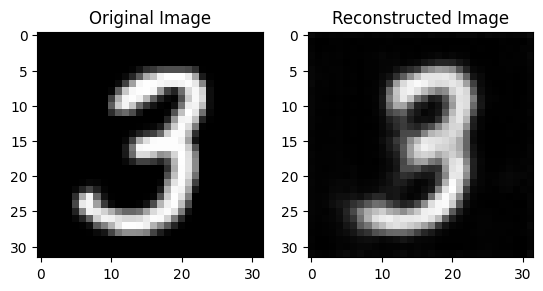

In [50]:
# Get reconstruction of test image
model.eval()
img, _ = next(iter(train_loader))
img = img.to(device)
recon, _ = model(img)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[0][0].cpu().detach().numpy(), cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(recon[0][0].cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Reconstructed Image')
plt.show()